In [1]:
%matplotlib widget

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

Estimated friction for Baseline run_in:
coulomb: 0.11288[Nm], (0.11482, -0.11095)
viscous: 0.00782 [Nm/(rev/s)], (0.00787, 0.00777)
Estimated friction for Conic Initial:
coulomb: 5.92427[Nm], (6.44712, -5.40142)
viscous: -1.34422 [Nm/(rev/s)], (-1.64042, -1.04803)
Estimated friction for Conic no-preload:
coulomb: 2.94587[Nm], (2.97703, -2.91470)
viscous: 1.42353 [Nm/(rev/s)], (1.93430, 0.91276)


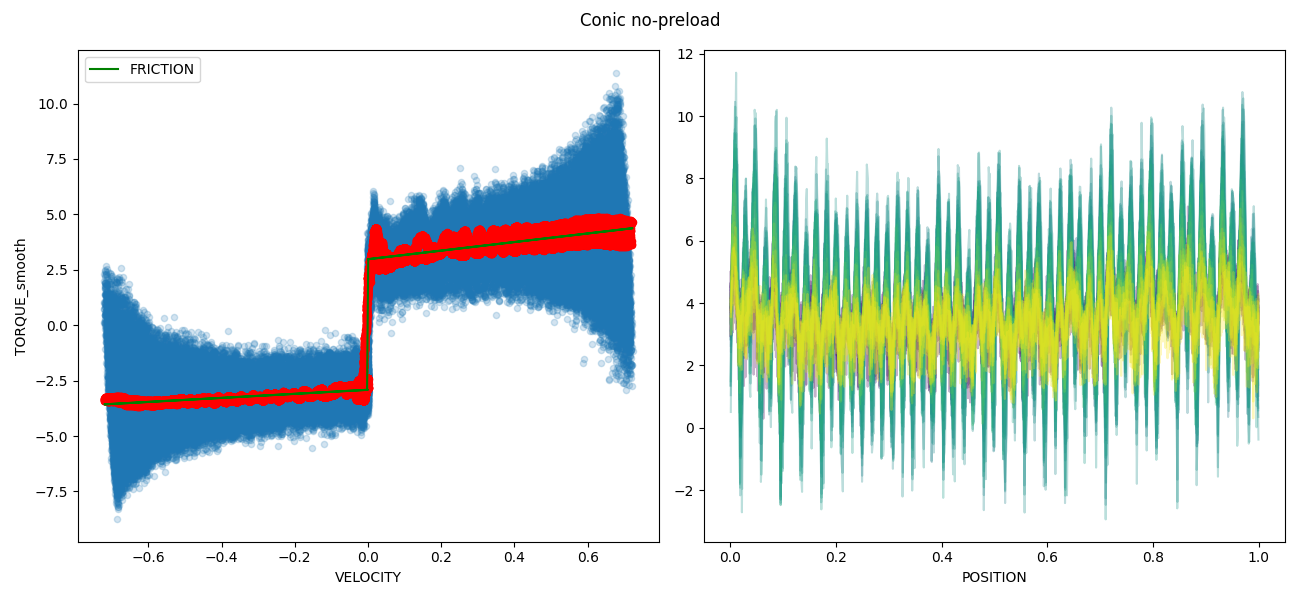

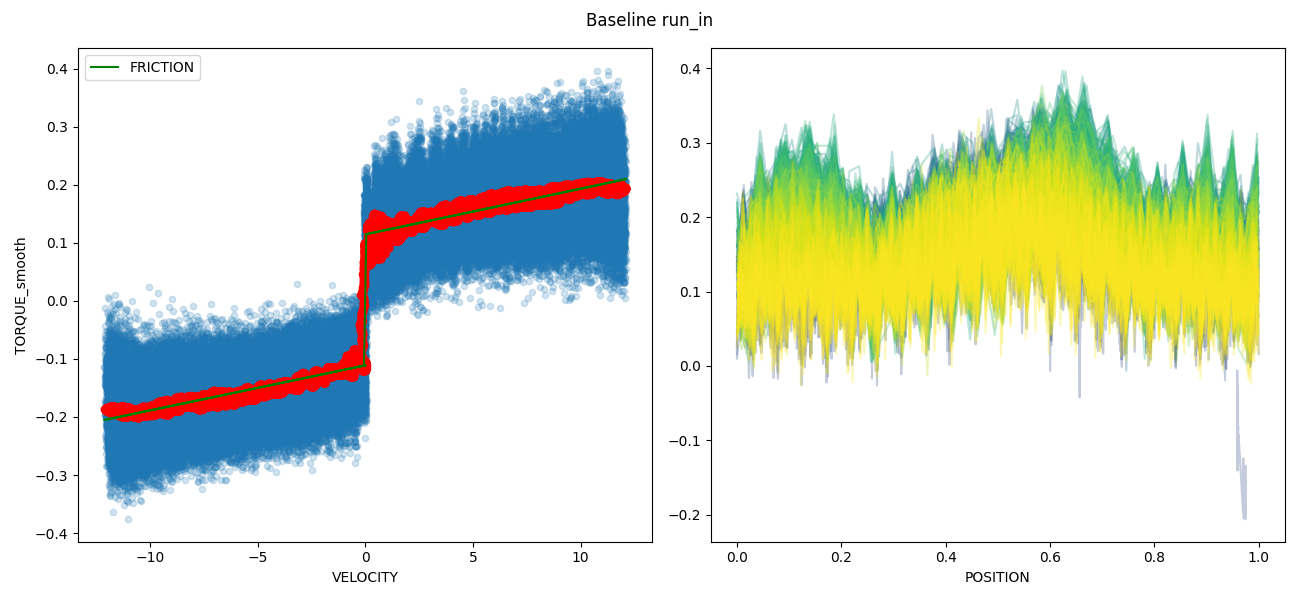

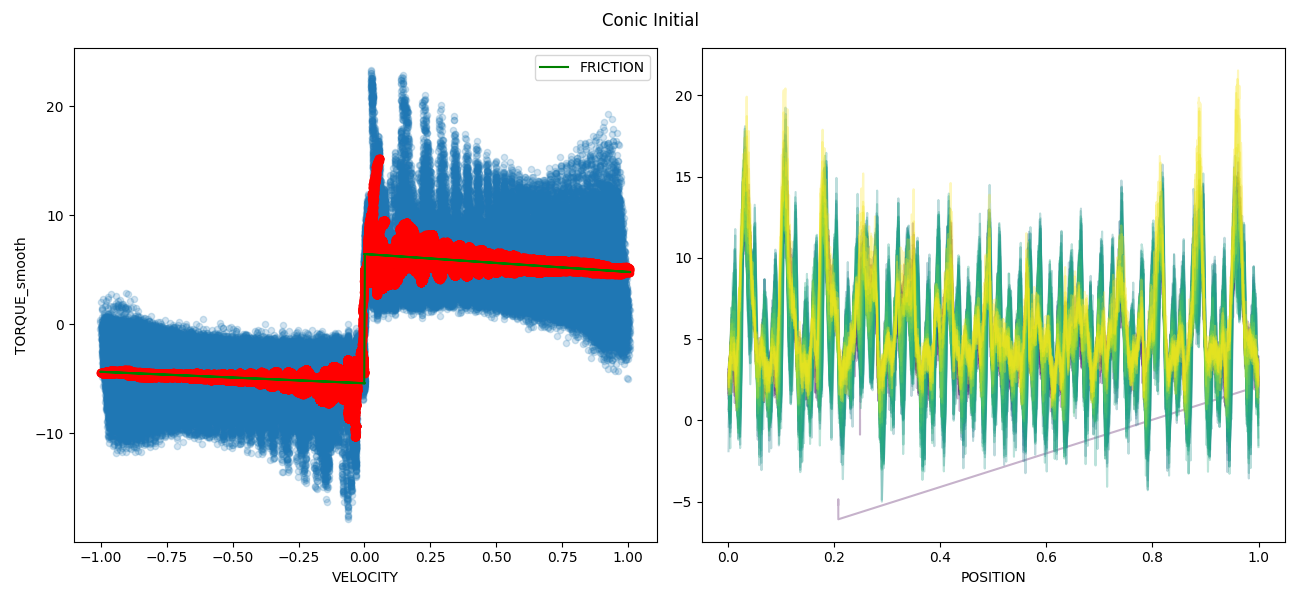

In [3]:
test_data = {
    # 'Motor only': '../../code/data/speedramp_2024-05-31_19-44-11.csv',
    # 'Baseline reducer': '../../../data/speedramp_baseline1_240s_14.0rps_06-13_10-36-37.csv',
    # 'Conic (no preload)': '../../../data/speedramp_360s_14.0rps_06-12_16-47-04.csv',
    # 'Baseline second assembly': '../../data/06-18_16-57-33_speedramp_baseline second assembly_240s_10.0rps.csv',

    # 'Baseline run_in': 'test_data/06-20_14-07-21_speedramp_Baseline PCCF_240s_12.0rps.csv',
    # 'Conic Initial': 'test_data/06-27_15-11-19_speedramp_conic init_240s_1.0rps.csv',

    'Conic Initial': 'test_data/2024-07-08__10-15-02_speedramp_conic_240s.csv',
    'Conic after run-in': 'test_data/2024-07-08__17-07-13_speedramp_conic runin_240s.csv',
}

def estimate_friction(df_vel_torque):
    # split data in positive and negative velocity
    positive_vt = df_vel_torque[df_vel_torque['VELOCITY'] > 0]
    negative_vt = df_vel_torque[df_vel_torque['VELOCITY'] < 0]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['VELOCITY'], positive_vt['TORQUE'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['VELOCITY'], negative_vt['TORQUE'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    #create model lines for pos and neg seperately
    pos_model = positive_vt.copy()
    pos_model['FRICTION'] = pos_viscous * pos_model['VELOCITY'] + pos_coulomb
    neg_model = negative_vt.copy()
    neg_model['FRICTION'] = neg_viscous * neg_model['VELOCITY'] + neg_coulomb

    # combine the two models
    fric_model = pd.concat([neg_model, pos_model])

    return fric_model

def average_data(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.1ms').mean()
        group = group.interpolate(method='time')
        print(f'group {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

        if len(data) > 100:
            break

    data = data[5:100]

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df

for name, path in test_data.items():
    #another test after cutting a bigger slot, and at a higher voltage:
    df = pd.read_csv(path)

    # to datetime
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.set_index('TIME', inplace=True)


    df['TORQUE_smooth'] = df['TORQUE'].rolling(window=400).mean()

    # plot measurements
    fig, axs = plt.subplots(1, 2, figsize=(13, 6))

    df.plot(x='VELOCITY', y='TORQUE', kind='scatter', alpha=0.2, ax=axs[0])
    df.plot(x='VELOCITY', y='TORQUE_smooth', kind='scatter', color='red', ax=axs[0])

    # plot estimated friction
    print(f'Estimated friction for {name}:')
    fric_model = estimate_friction(df)
    fric_model.plot(x='VELOCITY', y='FRICTION', color='green', ax=axs[0])

    # plot torque over position 
    df['REVOLUTIONS'] = np.floor(df['POSITION'])
    df['POSITION'] = df['POSITION'] - df['REVOLUTIONS']

    n_plots = int(df['REVOLUTIONS'].max())
    colors = plt.cm.viridis(np.linspace(0, 1, n_plots))
    for i in range(0, n_plots):
        rev = df[(df['REVOLUTIONS'] == i) & (df['VELOCITY'] > 0)]
        rev.plot(x='POSITION', y='TORQUE', ax=axs[1], color=colors[i], alpha=0.3, legend=False)

    # avg_fric = average_data(df, 'REVOLUTIONS')
    # avg_fric.plot(x='POSITION', y='TORQUE', color='red', ax=axs[1])

    fig.suptitle(name)
    fig.tight_layout()
    
plt.show()